In [37]:
import cv2
import os
import numpy as np
import keras
import torch
import torch.nn as nn
import torchvision.models as models
from keras import layers
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
TRAIN_DATASET_PATH = "/Users/project/Documents/College/FYP/Dataset_old/train"
TEST_DATASET_PATH = "/Users/project/Documents/College/FYP/Dataset_old/test"
NUM_CLASSES = 80
IMG_SIZE = 224
HASH_SIZE = 512
LEARNING_RATE = 0.0001
EPOCHS = 8

In [18]:
def gen_labels(DATASET_PATH):
    labels = []
    for name in os.listdir(DATASET_PATH):
        for _ in os.listdir(os.path.join(DATASET_PATH, name)):
            labels.append(name.split("_")[1])
    labels = [int(label)-1 for label in labels]
    return labels

def gen_path(DATASET_PATH):
    path = []
    for files in os.listdir(DATASET_PATH):
        for img in os.listdir(os.path.join(DATASET_PATH, files)):
            path.append(os.path.join(DATASET_PATH, files, img))
    return path

In [19]:
train_labels = gen_labels(DATASET_PATH=TRAIN_DATASET_PATH)
train_path = gen_path(DATASET_PATH=TRAIN_DATASET_PATH)
test_path = gen_path(DATASET_PATH=TEST_DATASET_PATH)
test_labels = gen_labels(DATASET_PATH=TEST_DATASET_PATH)

In [20]:
train_images = [cv2.resize(cv2.imread(x, cv2.IMREAD_COLOR_RGB),(IMG_SIZE, IMG_SIZE))  for x in train_path]
test_images = [cv2.resize(cv2.imread(x, cv2.IMREAD_COLOR_RGB),(IMG_SIZE, IMG_SIZE))  for x in test_path]
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_images = np.array(train_images).transpose(0, 3, 1, 2)
test_images = np.array(test_images).transpose(0, 3, 1, 2)

In [21]:
img_train, img_val, label_train, label_val = train_test_split(
    train_images, train_labels, test_size=0.4, random_state=42
)


In [22]:
train_dataset = TensorDataset(torch.tensor(img_train, dtype=torch.float32),
                              torch.tensor(label_train, dtype=torch.long).squeeze())
val_dataset = TensorDataset(torch.tensor(img_val, dtype=torch.float32),
                            torch.tensor(label_val, dtype=torch.long).squeeze())
test_dataset = TensorDataset(torch.tensor(test_images, dtype=torch.float32),
                            torch.tensor(test_labels, dtype=torch.long).squeeze())

In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CBAM(nn.Module):
    def __init__(self, in_planes, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_planes // reduction_ratio, in_planes, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (N, C)
        x = x.unsqueeze(2)  # (N, C, 1) to simulate 1D
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))
        max_out = self.fc(self.max_pool(x).squeeze(-1))
        scale = self.sigmoid(avg_out + max_out).unsqueeze(-1)  # (N, C, 1)
        x = x * scale  # Apply attention
        return x.squeeze(-1)  


In [ ]:
class FingerprintHashModel(nn.Module):
    def __init__(self, hash_size=HASH_SIZE, num_classes=None):
        super(FingerprintHashModel, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        num_ftrs = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Identity() 
        self.cbam = CBAM(num_ftrs)
        
        # Feature extraction layers
        self.feature_layers = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        
        self.hash_layer = nn.Sequential(
            nn.Linear(512, hash_size),
            nn.Tanh()  # Output range (-1, 1)
        )
        
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.cbam(x)
        features = self.feature_layers(x)
        hash_output = self.hash_layer(features)
        class_output = self.classifier(features)
        return hash_output, class_output
    
    def get_features(self, x):
        """Extract only the hash features"""
        with torch.no_grad():
            x = self.base_model(x)
            features = self.feature_layers(x)
            hash_output = self.hash_layer(features)
            return hash_output


In [61]:
class FingerprintOldHashModel(nn.Module):
    def __init__(self, hash_size=HASH_SIZE, num_classes=None):
        super(FingerprintOldHashModel, self).__init__()
        # Load pre-trained ResNet50 using the recommended 'weights' argument
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Get the number of features from the layer before the original fc layer
        num_ftrs = self.base_model.fc.in_features
        
        # Replace the last fully connected layer with an Identity layer
        self.base_model.fc = nn.Identity() 
        
        # Feature extraction layers
        self.feature_layers = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        

        self.hash_layer = nn.Sequential(
            nn.Linear(512, hash_size),
            nn.Tanh()  # Output range (-1, 1)
        )
        
        if num_classes is None:
            raise ValueError("num_classes must be specified for FingerprintHashModel")
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.base_model(x)
        features = self.feature_layers(x)
        hash_output = self.hash_layer(features)
        class_output = self.classifier(features)
        return hash_output, class_output
    
    def get_features(self, x):
        """Extract only the hash features"""
        with torch.no_grad():
            x = self.base_model(x)
            features = self.feature_layers(x)
            hash_output = self.hash_layer(features)
            return hash_output


In [52]:
def binarize_features(features, threshold=0.0):
    binary = (features > threshold).float()
    return binary

# Hamming distance calculation
def hamming_distance(hash1, hash2):
    return torch.sum(hash1 != hash2).item()

In [53]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            hash_outputs, outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                hash_outputs, outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = 100. * val_correct / val_total
        
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss = {epoch_loss:.4f}, Train Acc = {epoch_acc:.2f}%, "
              f"Val Loss = {val_epoch_loss:.4f}, Val Acc = {val_epoch_acc:.2f}%")
    
    return history

In [ ]:
model = FingerprintHashModel(hash_size=HASH_SIZE, num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6)

Epoch 1/6: Train Loss = 3.1934, Train Acc = 34.62%, Val Loss = 2.0424, Val Acc = 73.81%
Epoch 2/6: Train Loss = 1.6336, Train Acc = 79.17%, Val Loss = 1.1514, Val Acc = 90.84%
Epoch 3/6: Train Loss = 0.9764, Train Acc = 91.73%, Val Loss = 0.7091, Val Acc = 95.78%
Epoch 4/6: Train Loss = 0.6197, Train Acc = 96.17%, Val Loss = 0.5005, Val Acc = 96.28%
Epoch 5/6: Train Loss = 0.4478, Train Acc = 97.33%, Val Loss = 0.3831, Val Acc = 97.72%
Epoch 6/6: Train Loss = 0.3229, Train Acc = 98.38%, Val Loss = 0.3023, Val Acc = 97.66%


In [ ]:
torch.save(model.state_dict(), 'fingerprint_hash_model_attention.pth')

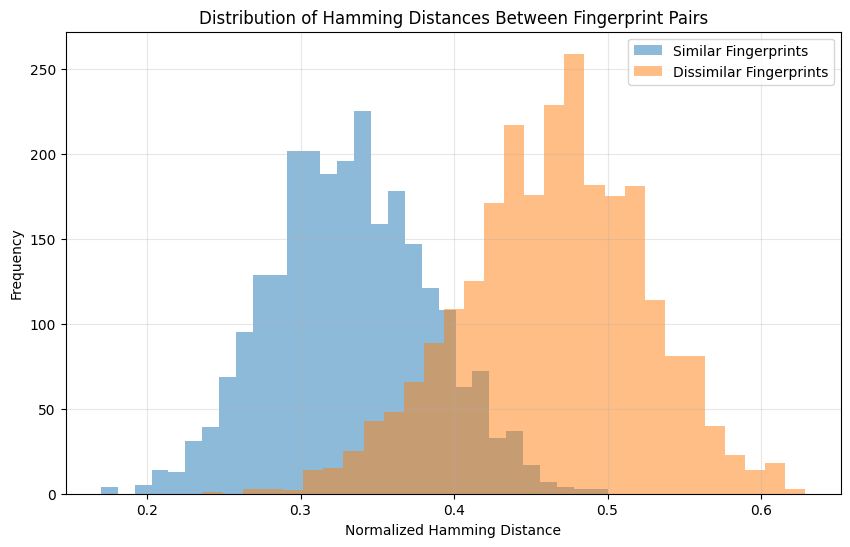

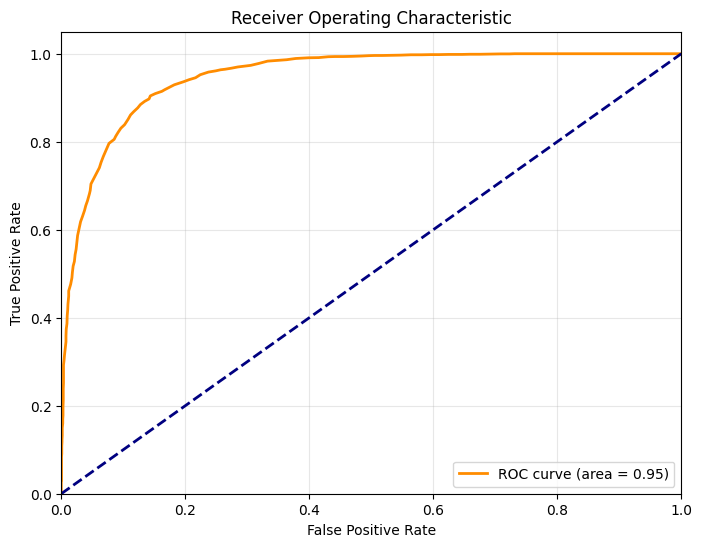

Average normalized Hamming distance between similar fingerprints: 0.3323
Average normalized Hamming distance between dissimilar fingerprints: 0.4640
AUC Score: 0.9486
Suggested threshold for similarity decision: 0.4004
At this threshold - True Positive Rate: 0.9041, False Positive Rate: 0.1436


In [30]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_fingerprint_similarity():
    # Set model to evaluation mode
    model.eval()
    
    # Extract features and labels from test set
    all_hashes = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            hash_outputs, _ = model(inputs)
            binary_hashes = binarize_features(hash_outputs)
            
            all_hashes.append(binary_hashes)
            all_labels.append(labels)
    
    all_hashes = torch.cat(all_hashes, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Create pairs for evaluation
    num_samples = len(all_labels)
    num_pairs = 5000  # Number of pairs to evaluate (adjust as needed)
    
    similar_distances = []
    dissimilar_distances = []
    true_labels = []  # 1 for similar, 0 for dissimilar
    distances = []    # All distances for ROC curve
    
    for _ in range(num_pairs):
        # Randomly select first fingerprint
        idx1 = random.randint(0, num_samples - 1)
        hash1 = all_hashes[idx1]
        label1 = all_labels[idx1]
        
        # With 50% probability, create a similar pair
        if random.random() < 0.5:
            # Find fingerprints with the same class
            same_class_indices = (all_labels == label1).nonzero(as_tuple=True)[0]
            # If there are other samples with the same class
            if len(same_class_indices) > 1:
                # Select a different sample from the same class
                idx2 = same_class_indices[random.randint(0, len(same_class_indices) - 1)]
                while idx2 == idx1:  # Ensure we don't pick the same sample
                    idx2 = same_class_indices[random.randint(0, len(same_class_indices) - 1)]
                
                hash2 = all_hashes[idx2]
                distance = hamming_distance(hash1, hash2)
                similar_distances.append(distance)
                distances.append(distance)
                true_labels.append(1)  # Similar pair
        else:
            # Find fingerprints with different classes
            diff_class_indices = (all_labels != label1).nonzero(as_tuple=True)[0]
            if len(diff_class_indices) > 0:
                # Select a sample from a different class
                idx2 = diff_class_indices[random.randint(0, len(diff_class_indices) - 1)]
                hash2 = all_hashes[idx2]
                distance = hamming_distance(hash1, hash2)
                dissimilar_distances.append(distance)
                distances.append(distance)
                true_labels.append(0)  # Dissimilar pair
    
    # Analyze the results
    # Normalize distances by hash size for comparison
    similar_distances_norm = [d / HASH_SIZE for d in similar_distances]
    dissimilar_distances_norm = [d / HASH_SIZE for d in dissimilar_distances]
    distances_norm = [d / HASH_SIZE for d in distances]
    
    # Plot histograms of distances
    plt.figure(figsize=(10, 6))
    plt.hist(similar_distances_norm, bins=30, alpha=0.5, label='Similar Fingerprints')
    plt.hist(dissimilar_distances_norm, bins=30, alpha=0.5, label='Dissimilar Fingerprints')
    plt.xlabel('Normalized Hamming Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Hamming Distances Between Fingerprint Pairs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate ROC curve and AUC
    # Note: For ROC curve, we need to invert distances since smaller distance means higher similarity
    fpr, tpr, thresholds = roc_curve(true_labels, [1 - d for d in distances_norm])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate summary statistics
    avg_similar_dist = sum(similar_distances_norm) / len(similar_distances_norm) if similar_distances_norm else 0
    avg_dissimilar_dist = sum(dissimilar_distances_norm) / len(dissimilar_distances_norm) if dissimilar_distances_norm else 0
    
    print(f"Average normalized Hamming distance between similar fingerprints: {avg_similar_dist:.4f}")
    print(f"Average normalized Hamming distance between dissimilar fingerprints: {avg_dissimilar_dist:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")
    
    # Threshold analysis
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = 1 - thresholds[optimal_idx]
    print(f"Suggested threshold for similarity decision: {optimal_threshold:.4f}")
    print(f"At this threshold - True Positive Rate: {tpr[optimal_idx]:.4f}, False Positive Rate: {fpr[optimal_idx]:.4f}")
    
    return {
        'similar_distances': similar_distances_norm,
        'dissimilar_distances': dissimilar_distances_norm,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold
    }

# Run the evaluation
similarity_results = evaluate_fingerprint_similarity()

In [ ]:
model = FingerprintOldHashModel(hash_size=HASH_SIZE, num_classes=NUM_CLASSES)

state_dict = torch.load('fingerprint_hash_model3.pth')
model.load_state_dict(state_dict)
model.eval()

FingerprintOldHashModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

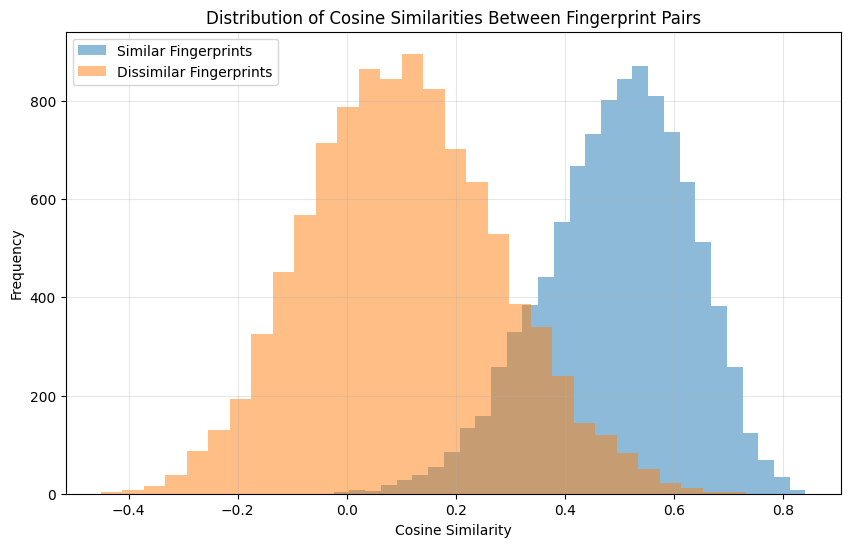

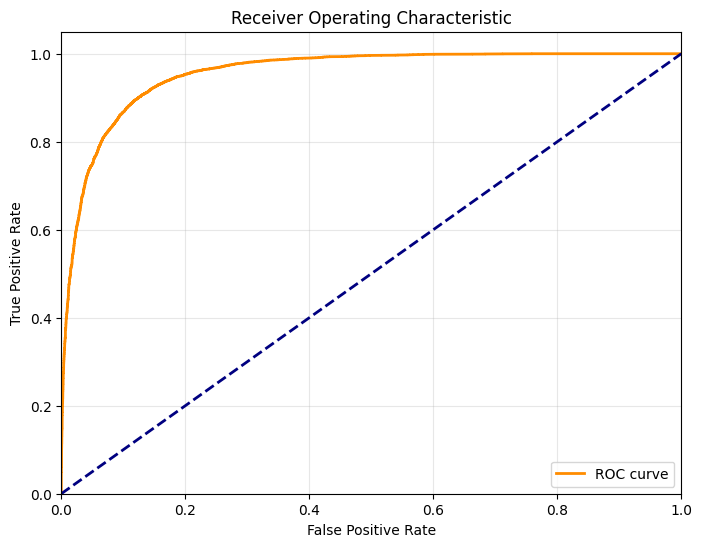

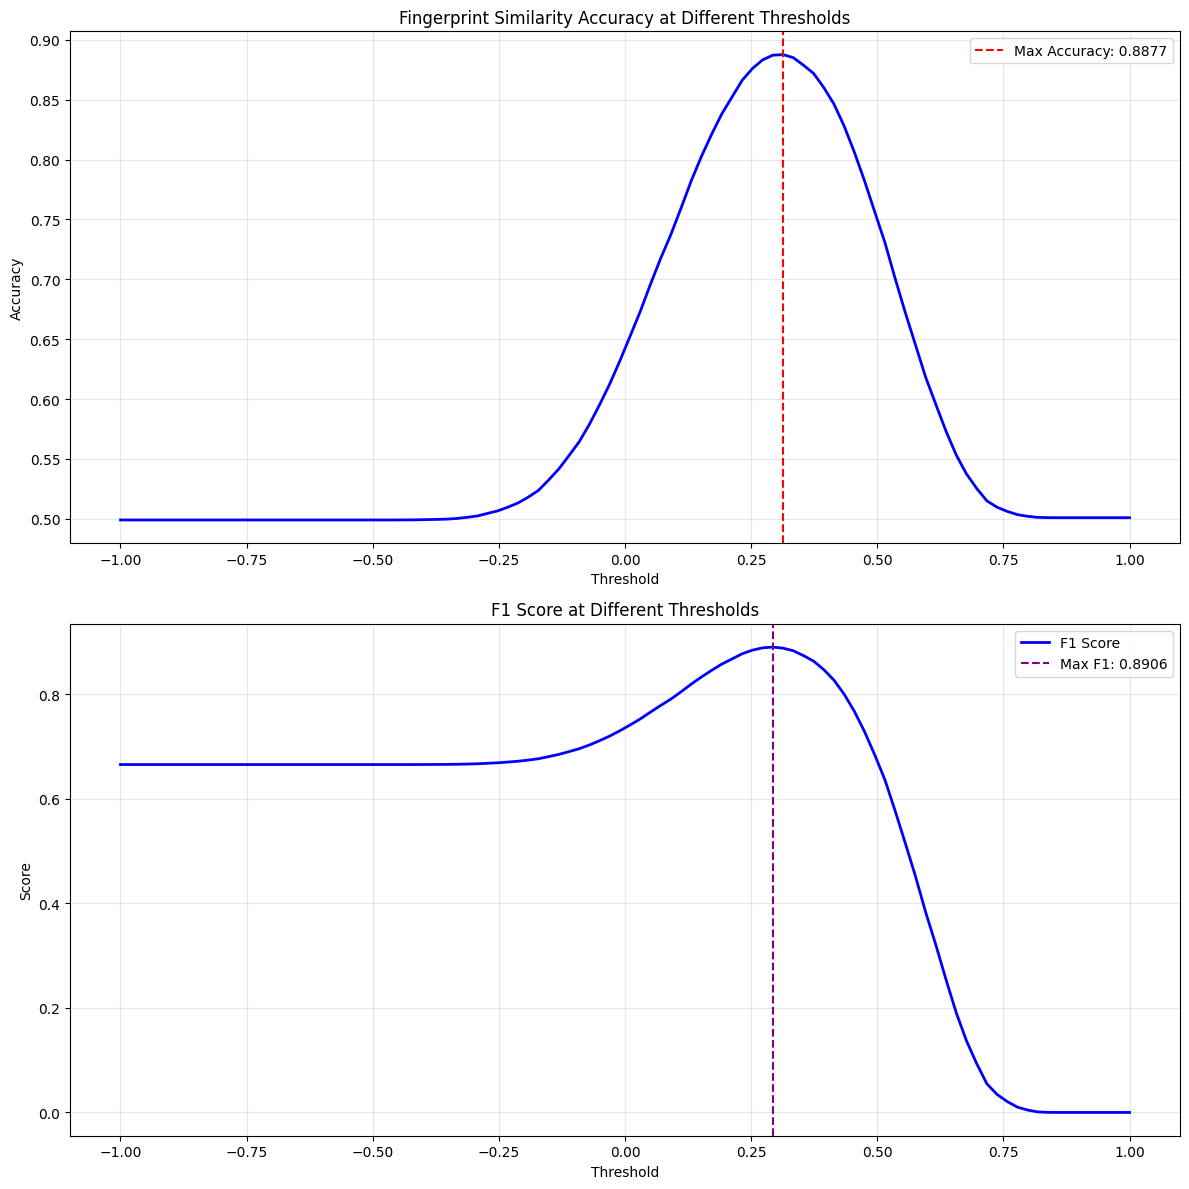

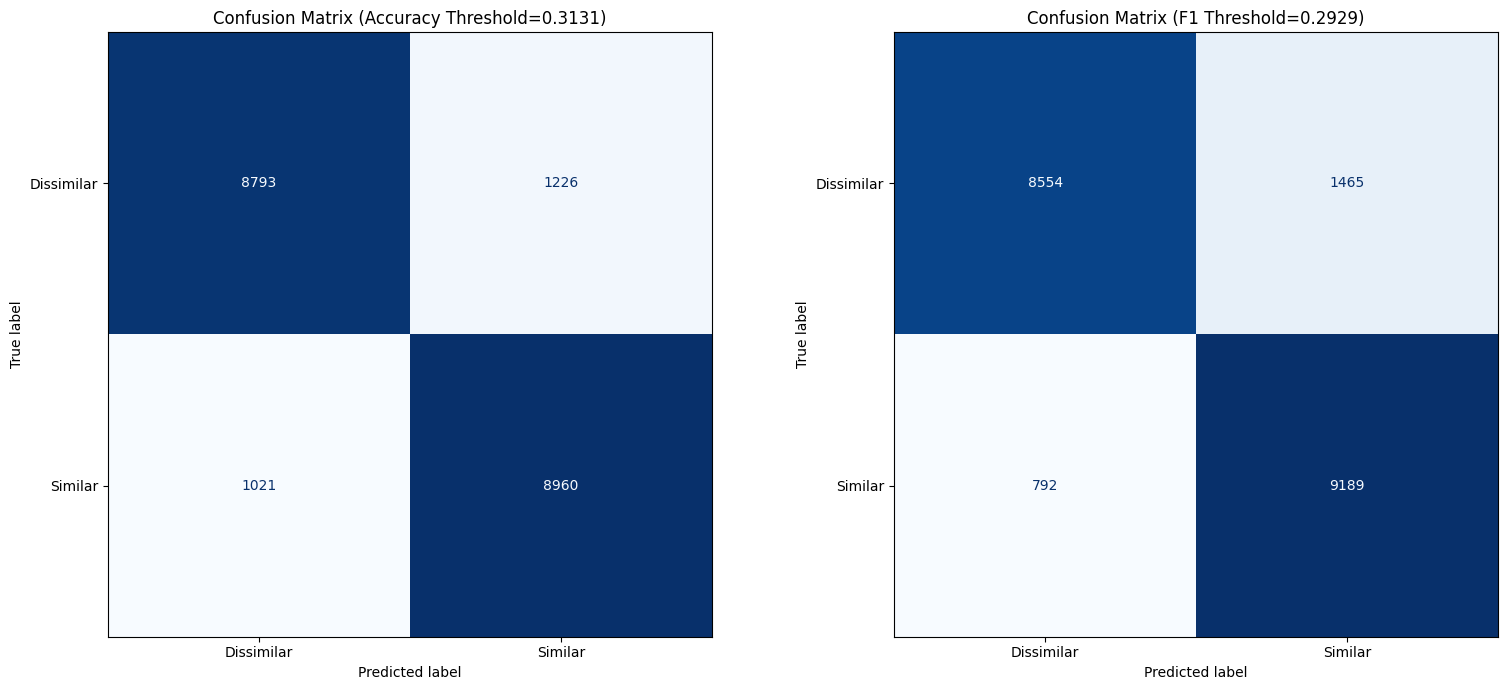

Maximum accuracy of 0.8877 at threshold = 0.3131
Maximum F1 score of 0.8906 at threshold = 0.2929


In [64]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

def cosine_similarity(hash1, hash2):
    """
    Calculate cosine similarity between two hash vectors.
    Range: -1 to 1, where 1 means identical, 0 means orthogonal, -1 means opposite.
    For fingerprint matching, higher values indicate greater similarity.
    """
    dot_product = torch.sum(hash1 * hash2)
    norm1 = torch.sqrt(torch.sum(hash1 * hash1))
    norm2 = torch.sqrt(torch.sum(hash2 * hash2))
    
    # Avoid division by zero
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

def evaluate_fingerprint_similarity_cosine():
    # Set model to evaluation mode
    model.eval()
    
    # Extract features and labels from test set
    all_hashes = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            hash_outputs, _ = model(inputs)
            # No need to binarize for cosine similarity
            all_hashes.append(hash_outputs)
            all_labels.append(labels)
    
    all_hashes = torch.cat(all_hashes, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Create pairs for evaluation
    num_samples = len(all_labels)
    num_pairs = 20000  # Number of pairs to evaluate
    
    similar_similarities = []
    dissimilar_similarities = []
    true_labels = []  # 1 for similar, 0 for dissimilar
    similarities = []  # All similarities for ROC curve
    
    for _ in range(num_pairs):
        # Randomly select first fingerprint
        idx1 = random.randint(0, num_samples - 1)
        hash1 = all_hashes[idx1]
        label1 = all_labels[idx1]
        
        # With 50% probability, create a similar pair
        if random.random() < 0.5:
            # Find fingerprints with the same class
            same_class_indices = (all_labels == label1).nonzero(as_tuple=True)[0]
            # If there are other samples with the same class
            if len(same_class_indices) > 1:
                # Select a different sample from the same class
                idx2 = same_class_indices[random.randint(0, len(same_class_indices) - 1)]
                while idx2 == idx1:  # Ensure we don't pick the same sample
                    idx2 = same_class_indices[random.randint(0, len(same_class_indices) - 1)]
                
                hash2 = all_hashes[idx2]
                similarity = cosine_similarity(hash1, hash2)
                similar_similarities.append(similarity)
                similarities.append(similarity)
                true_labels.append(1)  # Similar pair
        else:
            # Find fingerprints with different classes
            diff_class_indices = (all_labels != label1).nonzero(as_tuple=True)[0]
            if len(diff_class_indices) > 0:
                # Select a sample from a different class
                idx2 = diff_class_indices[random.randint(0, len(diff_class_indices) - 1)]
                hash2 = all_hashes[idx2]
                similarity = cosine_similarity(hash1, hash2)
                dissimilar_similarities.append(similarity)
                similarities.append(similarity)
                true_labels.append(0)  # Dissimilar pair
    
    # Convert to numpy arrays for plotting
    similarities = [s.item() for s in similarities]
    true_labels = np.array(true_labels)
    similar_similarities = [s.item() for s in similar_similarities]
    dissimilar_similarities = [s.item() for s in dissimilar_similarities]
    
    # Plot histograms of similarities
    plt.figure(figsize=(10, 6))
    plt.hist(similar_similarities, bins=30, alpha=0.5, label='Similar Fingerprints')
    plt.hist(dissimilar_similarities, bins=30, alpha=0.5, label='Dissimilar Fingerprints')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cosine Similarities Between Fingerprint Pairs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate ROC curve and AUC
    # Note: For ROC with cosine similarity, higher similarity means more similar
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate threshold accuracy
    thresholds_for_accuracy = np.linspace(-1.0, 1.0, 100)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds_for_accuracy:
        # Predict similarity based on threshold
        # If similarity > threshold, predict similar (1), else dissimilar (0)
        predictions = [1 if sim > threshold else 0 for sim in similarities]
        
        # Calculate accuracy
        correct = sum(pred == true for pred, true in zip(predictions, true_labels))
        accuracy = correct / len(predictions) if predictions else 0
        accuracies.append(accuracy)
        
        # Calculate precision, recall, F1 score
        true_positives = sum(pred == 1 and true == 1 for pred, true in zip(predictions, true_labels))
        false_positives = sum(pred == 1 and true == 0 for pred, true in zip(predictions, true_labels))
        false_negatives = sum(pred == 0 and true == 1 for pred, true in zip(predictions, true_labels))
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Find the threshold with maximum accuracy
    max_acc_idx = np.argmax(accuracies)
    max_acc_threshold = thresholds_for_accuracy[max_acc_idx]
    max_acc = accuracies[max_acc_idx]
    
    # Find the threshold with maximum F1 score
    max_f1_idx = np.argmax(f1_scores)
    max_f1_threshold = thresholds_for_accuracy[max_f1_idx]
    max_f1 = f1_scores[max_f1_idx]
    
    # Create figure with multiple plots
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: Accuracy vs threshold
    ax[0].plot(thresholds_for_accuracy, accuracies, 'b-', linewidth=2)
    ax[0].axvline(x=max_acc_threshold, color='r', linestyle='--', 
                 label=f'Max Accuracy: {max_acc:.4f}')
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Fingerprint Similarity Accuracy at Different Thresholds')
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()
    
    # Plot 2: Precision, Recall and F1-score vs threshold
    # ax[1].plot(thresholds_for_accuracy, precisions, 'g-', linewidth=2, label='Precision')
    # ax[1].plot(thresholds_for_accuracy, recalls, 'r-', linewidth=2, label='Recall')
    ax[1].plot(thresholds_for_accuracy, f1_scores, 'b-', linewidth=2, label='F1 Score')
    ax[1].axvline(x=max_f1_threshold, color='purple', linestyle='--',
                 label=f'Max F1: {max_f1:.4f}')
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Score')
    ax[1].set_title('F1 Score at Different Thresholds')
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create confusion matrices for both thresholds
    predictions_acc = [1 if sim > max_acc_threshold else 0 for sim in similarities]
    predictions_f1 = [1 if sim > max_f1_threshold else 0 for sim in similarities]
    
    # Calculate confusion matrices
    cm_acc = confusion_matrix(true_labels, predictions_acc)
    cm_f1 = confusion_matrix(true_labels, predictions_f1)
    
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot confusion matrix for accuracy-optimized threshold
    disp_acc = ConfusionMatrixDisplay(
        confusion_matrix=cm_acc,
        display_labels=["Dissimilar", "Similar"]
    )
    disp_acc.plot(
        ax=axes[0],
        cmap=plt.cm.Blues,
        values_format='d',
        colorbar=False
    )
    axes[0].set_title(f'Confusion Matrix (Accuracy Threshold={max_acc_threshold:.4f})')
    
    # Plot confusion matrix for F1-optimized threshold
    disp_f1 = ConfusionMatrixDisplay(
        confusion_matrix=cm_f1,
        display_labels=["Dissimilar", "Similar"]
    )
    disp_f1.plot(
        ax=axes[1],
        cmap=plt.cm.Blues,
        values_format='d',
        colorbar=False
    )
    axes[1].set_title(f'Confusion Matrix (F1 Threshold={max_f1_threshold:.4f})')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Maximum accuracy of {max_acc:.4f} at threshold = {max_acc_threshold:.4f}")
    print(f"Maximum F1 score of {max_f1:.4f} at threshold = {max_f1_threshold:.4f}")
    
    return {
        'similar_similarities': similar_similarities,
        'dissimilar_similarities': dissimilar_similarities,
        'roc_auc': roc_auc,
        'optimal_threshold_acc': max_acc_threshold,
        'max_accuracy': max_acc,
        'optimal_threshold_f1': max_f1_threshold,
        'max_f1': max_f1,
        'confusion_matrix_acc': cm_acc,
        'confusion_matrix_f1': cm_f1
    }

# Run the evaluation
cosine_results = evaluate_fingerprint_similarity_cosine()

In [63]:
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
FingerprintOldHashModel                       [1, 512]                  --
├─ResNet: 1-1                                 [1, 2048]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       